In [1]:
import pandas as pd
import numpy as np
from scipy.stats import truncnorm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor, DMatrix
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import random
from conditionalconformal import CondConf

In [2]:
def run_experiment(N):
    
   # Data generation
    Z_space = [3, 5, 7]
    z = np.random.choice(Z_space, N)
    x_sd = 1  
    
    x = np.random.normal(loc=z/10, scale=x_sd, size=N)
    y = np.exp(x) * z + truncnorm.rvs(-1, 1, loc=0, scale=1, size=N) + 1

    # Creating data frames
    half_N = int(N/2)
    D_cali = pd.DataFrame({'x': x[:half_N], 'y': y[:half_N], 'z': z[:half_N]})
    D_train = pd.DataFrame({'x': x[half_N:], 'y': y[half_N:], 'z': z[half_N:]}) 

    # Fit a eighth order polynomial
    poly = PolynomialFeatures(8)

    # Transform features
    X_poly = poly.fit_transform(D_train[['x', 'z']])

    # Train polynomial regression model
    reg = LinearRegression().fit(X_poly, D_train['y'])
    
    predictions = reg.predict(poly.transform(D_cali[['x', 'z']]))
    actual = np.exp(D_cali['x']) * D_cali['z'] + 1
    mse_cali = mean_squared_error(actual, predictions)
    
    # Calculate standard deviation of the errors
    errors = actual - predictions
    sd_errors = np.std(errors)
    
    
    return mse_cali, sd_errors

In [4]:
np.random.seed(1)
N_values = [100, 500, 1000, 5000, 10000, 50000]

num_iterations = 500
results_mse = []
results_sd = []
np.random.seed(1)
for N in N_values:
    mse_sum = 0
    sd_sum = 0
    for _ in range(num_iterations):
        mse, sd = run_experiment(N)
        mse_sum += mse
        sd_sum += sd
    average_mse = mse_sum / num_iterations
    average_sd = sd_sum / num_iterations
    results_mse.append(average_mse)
    results_sd.append(average_sd)



In [8]:
results_df = pd.DataFrame({'N': N_values, 'Average MSE': results_mse, 'Average SD': results_sd})
print(results_df)

       N   Average MSE  Average SD
0    100  1.764137e+06  333.604717
1    500  4.480603e+01    2.721339
2   1000  3.861856e+00    0.922444
3   5000  5.574788e-02    0.142998
4  10000  1.805907e-02    0.086558
5  50000  5.140143e-03    0.045262


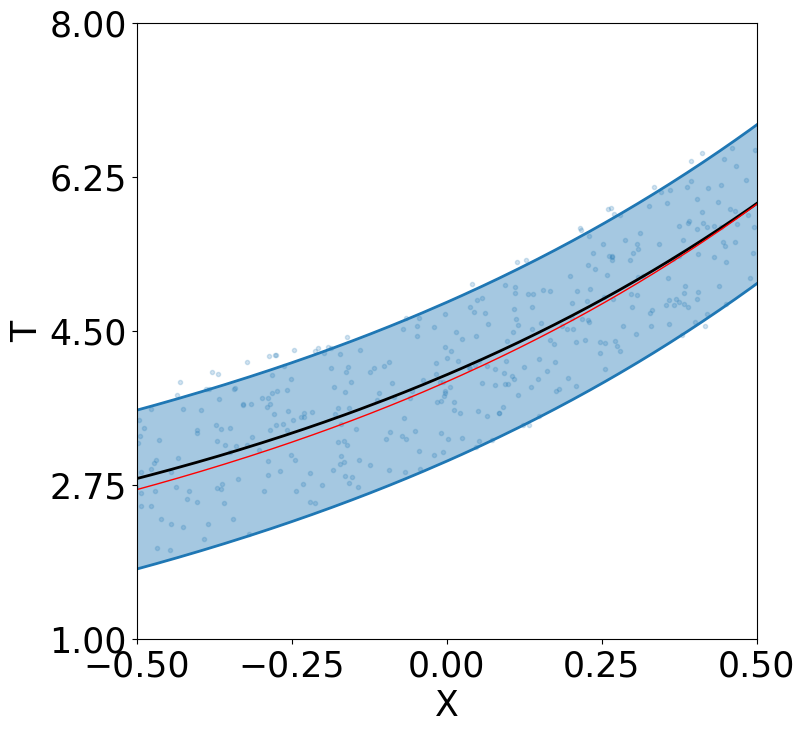

In [39]:
# Set the seed
np.random.seed(1)

Z_space = [3, 5, 7]
N = 1000
z = np.random.choice(Z_space, N)
x = np.random.normal(loc=z/10, scale=x_sd, size=N)
#x = stats.truncnorm.rvs(a=-2, b=2, loc=np.array(z) / 10, scale=x_sd, size=N)
y = np.exp(x)*z+truncnorm.rvs(-1, 1, loc=0, scale=1, size=N) + 1
# Creating data frames
half_N = int(N/2)
D_cali = pd.DataFrame({'x': x[:half_N], 'y': y[:half_N], 'z': z[:half_N]})
D_train = pd.DataFrame({'x': x[half_N:], 'y': y[half_N:], 'z': z[half_N:]})
# fit a sixth order polynomial
poly = PolynomialFeatures(6)
# 转换特征
X_poly = poly.fit_transform(D_train[['x', 'z']])
# 训练多项式回归模型
reg = LinearRegression().fit(X_poly, D_train['y'])
score_fn = lambda feature,  y : abs(y - reg.predict(poly.transform(pd.DataFrame({'x': feature[:,0], 'z': feature[:,1]}))))
condCovProgram = CondConf(score_fn, phi_fn, {})
condCovProgram.setup_problem(D_cali[['x', 'z']].to_numpy(),D_cali['y'].to_numpy())


# Data generation
z_0 = 3
m = 1000
z_new = np.full(m, z_0)
x_new = np.random.normal(loc=z_new/10, scale=x_sd, size=m)
#x_new = stats.truncnorm.rvs(a=-2, b=2, loc=np.array(z_new) / 10, scale=x_sd, size=m)
y_new = np.exp(x_new) * z_new + truncnorm.rvs(-1, 1, loc=0, scale=1, size=m) + 1
new_data = pd.DataFrame({'x': x_new, 'y': y_new, 'z': z_new})

dtest_new = pd.DataFrame({'x': x_new, 'z': z_new})
predicted_values_poly_new = reg.predict(poly.transform(dtest_new))
d = condCovProgram.predict(1-alpha, Xtest, lambda x, y : x)

hat_t_L = predicted_values_poly_new - d 
hat_t_U = predicted_values_poly_new + d 

cp = sns.color_palette()
sort_order = np.argsort(new_data['x'])
data = pd.DataFrame({
    'x': new_data['x'][sort_order],
    'y': new_data['y'][sort_order],
    'lower_ci': hat_t_L[sort_order],
    'upper_ci': hat_t_U[sort_order],
    'predicted': predicted_values_poly_new[sort_order],
    'true': np.exp(new_data['x'])[sort_order] * z_0 + 1
})
plt.figure(figsize=(8, 8))
plt.plot(new_data['x'][sort_order], new_data['y'][sort_order], '.', alpha=0.2)
#sns.scatterplot(x='x', y='y', data=data)
sns.lineplot(x='x', y='true', data=data, color= 'k', lw=2)#, label = "True")
sns.lineplot(x='x', y='predicted', data=data, color= 'red', lw=1)#, label = "Predict")
sns.lineplot(x='x', y='lower_ci', data=data, color=cp[0], lw=2)
sns.lineplot(x='x', y='upper_ci', data=data, color=cp[0], lw=2)
plt.fill_between(new_data['x'][sort_order], hat_t_L[sort_order], hat_t_U[sort_order], color=cp[0], alpha=0.4, label='Prediction Band')
plt.xlabel('X', fontsize=25)
plt.ylabel('T', fontsize=25)
plt.yticks(np.linspace(1, 8, 5),fontsize=25)#np.linspace(0, 12, 5) np.linspace(0, 18, 7)
plt.xticks(np.linspace(-0.5, 0.5, 5), fontsize=25)#np.linspace(-1, 1, 5)
#plt.title('Conditional Calibration when Z=5', fontsize=25)
plt.xlim(-0.5, 0.5)
plt.ylim(1, 8)
plt.grid(False)
# Adding a legend
#plt.legend(fontsize=20)
plt.show()

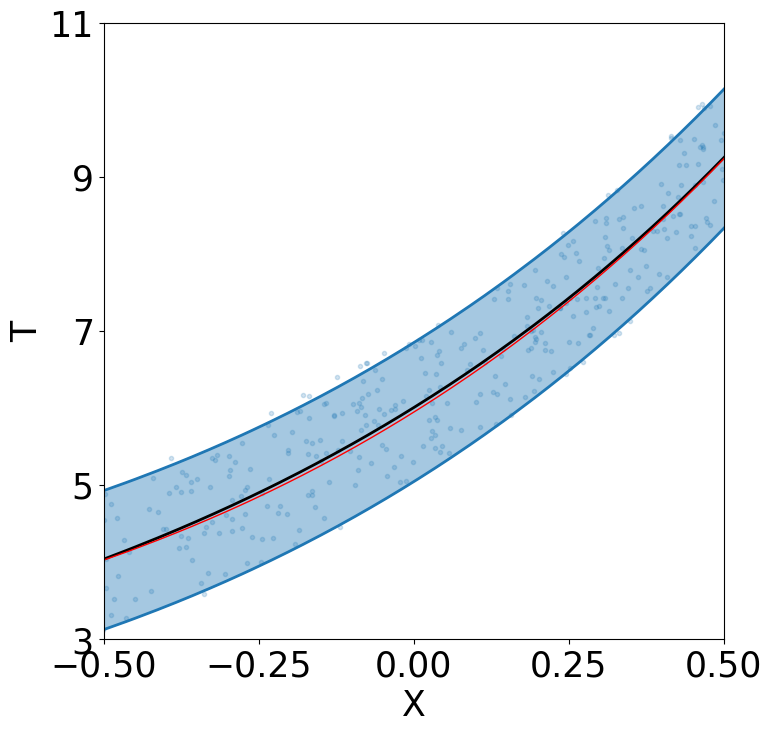

In [40]:
# Set the seed
np.random.seed(1)


Z_space = [3, 5, 7]
N = 1000
z = np.random.choice(Z_space, N)
x = np.random.normal(loc=z/10, scale=x_sd, size=N)
#x = stats.truncnorm.rvs(a=-2, b=2, loc=np.array(z) / 10, scale=x_sd, size=N)
y = np.exp(x)*z+truncnorm.rvs(-1, 1, loc=0, scale=1, size=N) + 1
# Creating data frames
half_N = int(N/2)
D_cali = pd.DataFrame({'x': x[:half_N], 'y': y[:half_N], 'z': z[:half_N]})
D_train = pd.DataFrame({'x': x[half_N:], 'y': y[half_N:], 'z': z[half_N:]})
# fit a sixth order polynomial
poly = PolynomialFeatures(6)
# 转换特征
X_poly = poly.fit_transform(D_train[['x', 'z']])
# 训练多项式回归模型
reg = LinearRegression().fit(X_poly, D_train['y'])
score_fn = lambda feature,  y : abs(y - reg.predict(poly.transform(pd.DataFrame({'x': feature[:,0], 'z': feature[:,1]}))))
condCovProgram = CondConf(score_fn, phi_fn, {})
condCovProgram.setup_problem(D_cali[['x', 'z']].to_numpy(),D_cali['y'].to_numpy())


# Data generation
z_0 = 5
m = 1000
z_new = np.full(m, z_0)
x_new = np.random.normal(loc=z_new/10, scale=x_sd, size=m)
#x_new = stats.truncnorm.rvs(a=-2, b=2, loc=np.array(z_new) / 10, scale=x_sd, size=m)
y_new = np.exp(x_new) * z_new + truncnorm.rvs(-1, 1, loc=0, scale=1, size=m) + 1
new_data = pd.DataFrame({'x': x_new, 'y': y_new, 'z': z_new})

dtest_new = pd.DataFrame({'x': x_new, 'z': z_new})
predicted_values_poly_new = reg.predict(poly.transform(dtest_new))
d = condCovProgram.predict(1-alpha, Xtest, lambda x, y : x)

hat_t_L = predicted_values_poly_new - d 
hat_t_U = predicted_values_poly_new + d 
cp = sns.color_palette()
sort_order = np.argsort(new_data['x'])
data = pd.DataFrame({
    'x': new_data['x'][sort_order],
    'y': new_data['y'][sort_order],
    'lower_ci': hat_t_L[sort_order],
    'upper_ci': hat_t_U[sort_order],
    'predicted': predicted_values_poly_new[sort_order],
    'true': np.exp(new_data['x'])[sort_order] * z_0 + 1
})
plt.figure(figsize=(8, 8))
plt.plot(new_data['x'][sort_order], new_data['y'][sort_order], '.', alpha=0.2)
#sns.scatterplot(x='x', y='y', data=data)
sns.lineplot(x='x', y='true', data=data, color= 'k', lw=2)#, label = "True")
sns.lineplot(x='x', y='predicted', data=data, color= 'red', lw=1)#, label = "Predict")
sns.lineplot(x='x', y='lower_ci', data=data, color=cp[0], lw=2)
sns.lineplot(x='x', y='upper_ci', data=data, color=cp[0], lw=2)
plt.fill_between(new_data['x'][sort_order], hat_t_L[sort_order], hat_t_U[sort_order], color=cp[0], alpha=0.4, label='Prediction Band')
plt.xlabel('X', fontsize=25)
plt.ylabel('T', fontsize=25)
plt.yticks(np.linspace(3, 11, 5),fontsize=25)#np.linspace(0, 12, 5) np.linspace(0, 18, 7)
plt.xticks(np.linspace(-0.5, 0.5, 5), fontsize=25)#np.linspace(-1, 1, 5)
#plt.title('Conditional Calibration when Z=5', fontsize=25)
plt.xlim(-0.5, 0.5)
plt.ylim(3, 11)
plt.grid(False)
# Adding a legend
#plt.legend(fontsize=20)
plt.show()

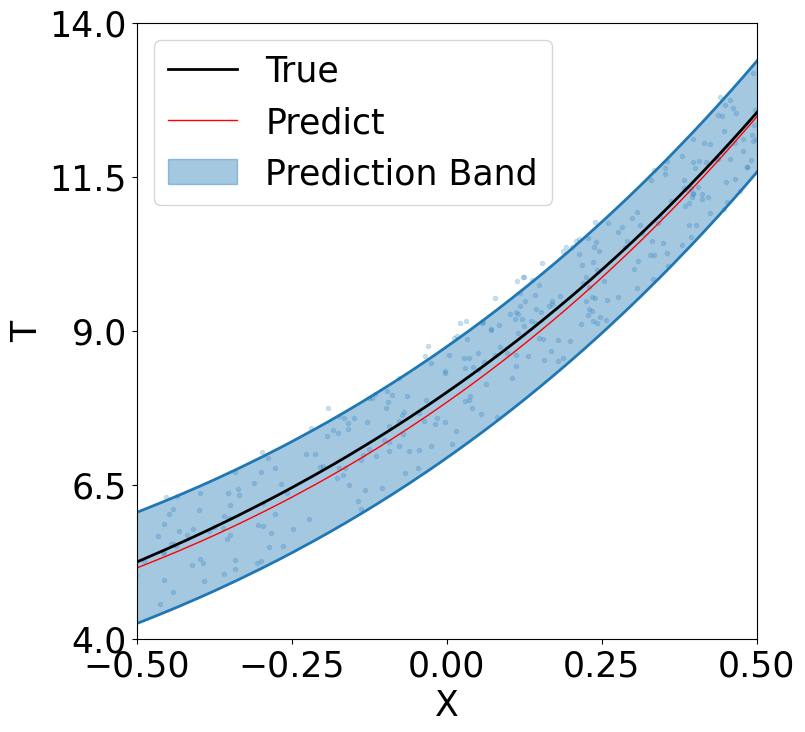

In [41]:
# Set the seed
np.random.seed(1)

Z_space = [3, 5, 7]
N = 1000
z = np.random.choice(Z_space, N)
x = np.random.normal(loc=z/10, scale=x_sd, size=N)
#x = stats.truncnorm.rvs(a=-2, b=2, loc=np.array(z) / 10, scale=x_sd, size=N)
y = np.exp(x)*z+truncnorm.rvs(-1, 1, loc=0, scale=1, size=N) + 1
# Creating data frames
half_N = int(N/2)
D_cali = pd.DataFrame({'x': x[:half_N], 'y': y[:half_N], 'z': z[:half_N]})
D_train = pd.DataFrame({'x': x[half_N:], 'y': y[half_N:], 'z': z[half_N:]})
# fit a sixth order polynomial
poly = PolynomialFeatures(6)
X_poly = poly.fit_transform(D_train[['x', 'z']])
reg = LinearRegression().fit(X_poly, D_train['y'])
score_fn = lambda feature,  y : abs(y - reg.predict(poly.transform(pd.DataFrame({'x': feature[:,0], 'z': feature[:,1]}))))
condCovProgram = CondConf(score_fn, phi_fn, {})
condCovProgram.setup_problem(D_cali[['x', 'z']].to_numpy(),D_cali['y'].to_numpy())


# Data generation
z_0 = 7
m = 1000
z_new = np.full(m, z_0)
x_new = np.random.normal(loc=z_new/10, scale=x_sd, size=m)
#x_new = stats.truncnorm.rvs(a=-2, b=2, loc=np.array(z_new) / 10, scale=x_sd, size=m)
y_new = np.exp(x_new) * z_new + truncnorm.rvs(-1, 1, loc=0, scale=1, size=m) + 1
new_data = pd.DataFrame({'x': x_new, 'y': y_new, 'z': z_new})

dtest_new = pd.DataFrame({'x': x_new, 'z': z_new})
predicted_values_poly_new = reg.predict(poly.transform(dtest_new))
d = condCovProgram.predict(1-alpha, Xtest, lambda x, y : x)

hat_t_L = predicted_values_poly_new - d 
hat_t_U = predicted_values_poly_new + d 

cp = sns.color_palette()
sort_order = np.argsort(new_data['x'])
data = pd.DataFrame({
    'x': new_data['x'][sort_order],
    'y': new_data['y'][sort_order],
    'lower_ci': hat_t_L[sort_order],
    'upper_ci': hat_t_U[sort_order],
    'predicted': predicted_values_poly_new[sort_order],
    'true': np.exp(new_data['x'])[sort_order] * z_0 + 1
})
plt.figure(figsize=(8, 8))
plt.plot(new_data['x'][sort_order], new_data['y'][sort_order], '.', alpha=0.2)
#sns.scatterplot(x='x', y='y', data=data)
sns.lineplot(x='x', y='true', data=data, color= 'k', lw=2, label = "True")
sns.lineplot(x='x', y='predicted', data=data, color= 'red', lw=1, label = "Predict")
sns.lineplot(x='x', y='lower_ci', data=data, color=cp[0], lw=2)
sns.lineplot(x='x', y='upper_ci', data=data, color=cp[0], lw=2)
plt.fill_between(new_data['x'][sort_order], hat_t_L[sort_order], hat_t_U[sort_order], color=cp[0], alpha=0.4, label='Prediction Band')
plt.xlabel('X', fontsize=25)
plt.ylabel('T', fontsize=25)
plt.yticks(np.linspace(4, 14, 5),fontsize=25)#np.linspace(0, 12, 5) np.linspace(0, 18, 7)
plt.xticks(np.linspace(-0.5, 0.5, 5), fontsize=25)#np.linspace(-1, 1, 5)
#plt.title('Conditional Calibration when Z=5', fontsize=25)
plt.xlim(-0.5, 0.5)
plt.ylim(4, 14)
plt.grid(False)
# Adding a legend
plt.legend(fontsize=25, loc='upper left')
plt.show()

In [42]:

def conformal_predict_z_0(alpha=0.1, m=2500, z_0=3):
    IR = []
    for j in range(200):
        #np.random.randint(0,100000)
        # Data generation
        Z_space = [3, 5, 7]
        N = 1000
        z = np.random.choice(Z_space, N)
        x = np.random.normal(loc=z/10, scale=x_sd, size=N)
        #x = stats.truncnorm.rvs(a=-2, b=2, loc=np.array(z) / 10, scale=x_sd, size=N)
        y = np.exp(x)*z+truncnorm.rvs(-1, 1, loc=0, scale=1, size=N) + 1
        # Creating data frames
        half_N = int(N/2)
        D_cali = pd.DataFrame({'x': x[:half_N], 'y': y[:half_N], 'z': z[:half_N]})
        D_train = pd.DataFrame({'x': x[half_N:], 'y': y[half_N:], 'z': z[half_N:]})
        # fit a sixth order polynomial
        poly = PolynomialFeatures(6)
        X_poly = poly.fit_transform(D_train[['x', 'z']])
        reg = LinearRegression().fit(X_poly, D_train['y'])
        score_fn = lambda feature,  y : abs(y - reg.predict(poly.transform(pd.DataFrame({'x': feature[:,0], 'z': feature[:,1]}))))
        condCovProgram = CondConf(score_fn, phi_fn, {})
        condCovProgram.setup_problem(D_cali[['x', 'z']].to_numpy(),D_cali['y'].to_numpy())
        
        z_new = np.full(m, z_0)
        #x_new = stats.truncnorm.rvs(a=-z_new, b=z_new, loc=np.array(z_new) / 10, scale=x_sd, size=m)
        x_new = np.random.normal(loc=z_new/10, scale=x_sd, size=m)
        y_new = np.exp(x_new) * z_new + truncnorm.rvs(-1, 1, loc=0, scale=1, size=m) + 1
        # Create new data
        new_data = pd.DataFrame({'x': x_new, 'y': y_new, 'z': z_new})
        dtest_new = pd.DataFrame({'x': x_new, 'z': z_new})
        predicted_values_poly_new = reg.predict(poly.transform(dtest_new))
        Xtest = np.array([new_data[['x', 'z']].to_numpy()[11,:]])
        d = condCovProgram.predict(1-alpha, Xtest, lambda x, y : x)
        # Calculate intervals
        hat_t_L = predicted_values_poly_new - d
        hat_t_U = predicted_values_poly_new + d
        IR.append(np.mean((hat_t_L <= new_data['y']) & (new_data['y'] <= hat_t_U) ))
    return IR, d

In [43]:
np.random.seed(1)
IR_7, d_7 = conformal_predict_z_0(alpha=0.1, m=1000, z_0=7)
IR_3, d_3 = conformal_predict_z_0(alpha=0.1, m=1000, z_0=3)
IR_5, d_5 = conformal_predict_z_0(alpha=0.1, m=1000, z_0=5)


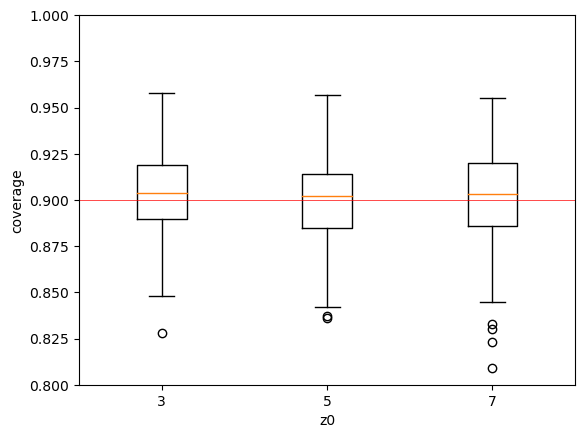

In [44]:
data = [IR_3, IR_5, IR_7]
fig, ax = plt.subplots()
ax.boxplot(data, labels=[3, 5, 7])
ax.axhline(y=1-alpha, color='red', linestyle='-', label='', linewidth=0.5)
plt.ylim(0.8, 1)
plt.xlabel('z0')
plt.ylabel('coverage')
plt.show()

In [45]:
def conformal_predict(m=1000, z_0=3, N = 1000):
    # Data generation
    Z_space = [3, 5, 7]
    z = np.random.choice(Z_space, N)
    x = np.random.normal(loc=z/10, scale=x_sd, size=N)
    #x = stats.truncnorm.rvs(a=-2, b=2, loc=np.array(z) / 10, scale=x_sd, size=N)
    y = np.exp(x)*z+truncnorm.rvs(-1, 1, loc=0, scale=1, size=N) + 1
    # Creating data frames
    half_N = int(N/2)
    D_cali = pd.DataFrame({'x': x[:half_N], 'y': y[:half_N], 'z': z[:half_N]})
    D_train = pd.DataFrame({'x': x[half_N:], 'y': y[half_N:], 'z': z[half_N:]})
    # fit a eighth order polynomial
    poly = PolynomialFeatures(8)
    X_poly = poly.fit_transform(D_train[['x', 'z']])
    reg = LinearRegression().fit(X_poly, D_train['y'])    
    score_fn = lambda feature,  y : abs(y - reg.predict(poly.transform(pd.DataFrame({'x': feature[:,0], 'z': feature[:,1]}))))
    condCovProgram = CondConf(score_fn, phi_fn, {})
    condCovProgram.setup_problem(D_cali[['x', 'z']].to_numpy(),D_cali['y'].to_numpy())
    
    
    z_new = np.full(m, z_0)
   #x_new = truncnorm.rvs(a=-z_new, b=z_new, loc=np.array(z_new) / 10, scale=x_sd, size=m)
    x_new = np.random.normal(loc=z_new/10, scale=x_sd, size=m)
    y_new = np.exp(x_new) * z_new + truncnorm.rvs(-1, 1, loc=0, scale=1, size=m) + 1
    new_data = pd.DataFrame({'x': x_new, 'y': y_new, 'z': z_new})
    dtest_new = pd.DataFrame(new_data[['x', 'z']])
    predicted_values_poly_new = reg.predict(poly.transform(dtest_new))
    Xtest = np.array([new_data[['x', 'z']].to_numpy()[11,:]])
    d = condCovProgram.predict(1-alpha, Xtest, lambda x, y : x)
        
    reserve_price = predicted_values_poly_new - d
    virtual_value = new_data['y'] * (new_data['y'] > reserve_price)
    
    # Find the index(es) of the maximum virtual value
    max_virtual_value_indexes = np.where(virtual_value == np.max(virtual_value))[0]

    winner = None
    if len(max_virtual_value_indexes) > 1:
    # Check the reserve price for the max virtual value indexes
        max_reserve_price_indexes = np.where(reserve_price[max_virtual_value_indexes] == np.max(reserve_price[max_virtual_value_indexes]))[0]

        if len(max_reserve_price_indexes) > 1:
        # If multiple maximums, choose one at random
            winner = np.random.choice(max_virtual_value_indexes[max_reserve_price_indexes])
        else:
        # If only one maximum
            winner = max_virtual_value_indexes[max_reserve_price_indexes[0]]
    else:
    # If only one maximum virtual value
        winner = max_virtual_value_indexes[0]
    

    sorted_virtual_value = np.sort(virtual_value)[::-1]
    payment = max(0, sorted_virtual_value[1], reserve_price[winner])
    max_welfare = np.max(new_data['y'])

    return payment, payment/max_welfare, payment - np.sort(new_data['y'])[::-1][1], np.sort(new_data['y'])[::-1][1], max_welfare

In [78]:
np.random.seed(1)
m_0 = 50
IR_3_compare = []
ratio_3 = []
Pay_3 = []

for i in range(200):
    result = conformal_predict(m=m_0, z_0=3)
    IR_3_compare.append(result[2])
    ratio_3.append(result[1])
    Pay_3.append(result[0])
    
IR_5_compare = []
ratio_5 = []
Pay_5 = []
for i in range(200):
    result = conformal_predict(m=m_0, z_0=5)
    IR_5_compare.append(result[2])
    ratio_5.append(result[1])
    Pay_5.append(result[0])

IR_7_compare = []
ratio_7 = []
Pay_7 = []
for i in range(200):
    result = conformal_predict(m=m_0, z_0=7)
    IR_7_compare.append(result[2])
    ratio_7.append(result[1])
    Pay_7.append(result[0])



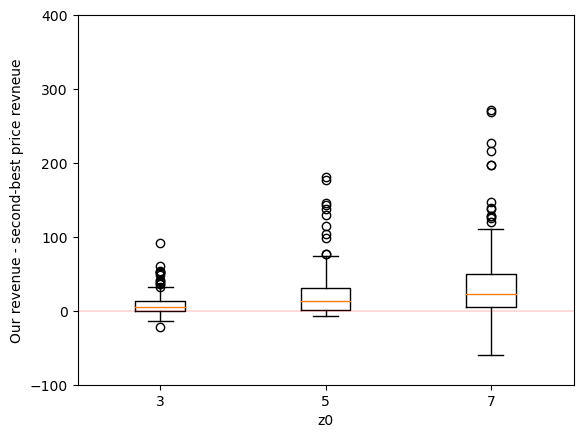

In [79]:
data = [IR_3_compare, IR_5_compare, IR_7_compare]
fig, ax = plt.subplots()
ax.boxplot(data, labels=[3, 5, 7])
ax.axhline(y=0, color='red', linestyle='-', label='', linewidth=0.2)

plt.xlabel('z0')
plt.ylabel('Our revenue - second-best price revneue')
plt.ylim(-100,400)
plt.show()

In [48]:
np.random.seed(1)
N_values = [100, 500, 1000, 2500, 5000]
z_0 = 3
num_runs = 1000


results = {"payment": [], "sb_value": [], "max_welfare": []}


for N in N_values:
    payments, sb_values, max_welfares = [], [], []
    for _ in range(num_runs):
        payment, _, _, sb_value, max_welfare = conformal_predict(50, z_0, N)
        payments.append(payment)
        sb_values.append(sb_value)
        max_welfares.append(max_welfare)
    results["payment"].append(np.mean(payments))
    results["sb_value"].append(np.mean(sb_values))
    results["max_welfare"].append(np.mean(max_welfares))

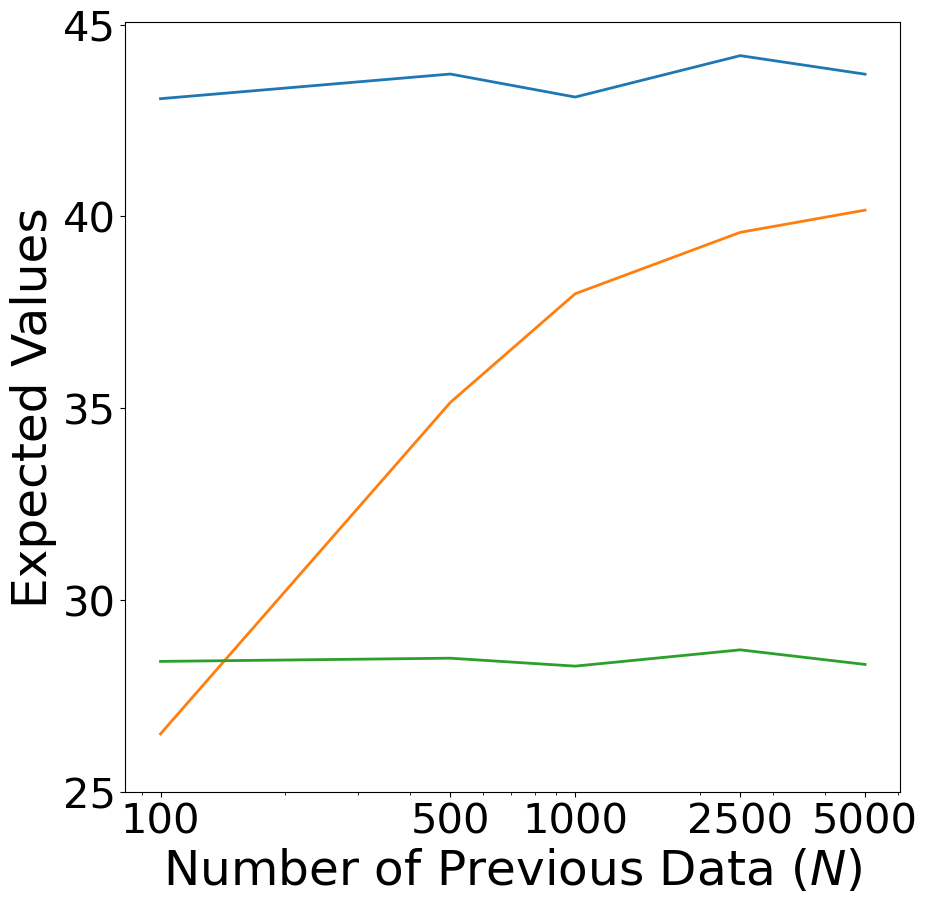

In [77]:


# 假设 N_values 和 results 是已经定义好的数据
# N_values = [...]
# results = {"payment": [...], "sb_value": [...], "max_welfare": [...]}

plt.figure(figsize=(10, 10))  # 修改此处以创建正方形的图形
plt.plot(N_values, results["max_welfare"], label="Max Welfare", linewidth=2)  # 加粗线条
plt.plot(N_values, results["payment"], label="Payment", linewidth=2)  # 加粗线条
plt.plot(N_values, results["sb_value"], label="2nd Best Price", linewidth=2)  # 加粗线条


# 设置坐标轴标签和字体大小
plt.xlabel("Number of Previous Data ($N$)", fontsize=35)
plt.ylabel("Expected Values", fontsize=35)

# 设置图例和字体大小
#plt.legend(fontsize=30, bbox_to_anchor=(0.49, 0.45), loc='center left')

# 设置横坐标为对数尺度，并确保刻度清晰
plt.xscale("log")

# 设置刻度标签的字体大小
plt.xticks(N_values, labels=[str(N) for N in N_values], fontsize=30)
plt.yticks(np.linspace(25, 45, 5), fontsize=30)

plt.show()



In [51]:
np.random.seed(1)
# 设置 N 的不同值
N_values = [100, 500, 1000, 2500, 5000]
z_0 = 5
num_runs = 1000

# 初始化用于存储结果的字典
results_5 = {"payment_5": [], "sb_value_5": [], "max_welfare_5": []}

# 对于每个 N 值，运行函数 200 次并计算平均值
for N in N_values:
    payments_5, sb_values_5, max_welfares_5 = [], [], []
    for _ in range(num_runs):
        payment, _, _, sb_value, max_welfare = conformal_predict(50, z_0, N)
        payments_5.append(payment)
        sb_values_5.append(sb_value)
        max_welfares_5.append(max_welfare)
    results_5["payment_5"].append(np.mean(payments_5))
    results_5["sb_value_5"].append(np.mean(sb_values_5))
    results_5["max_welfare_5"].append(np.mean(max_welfares_5))

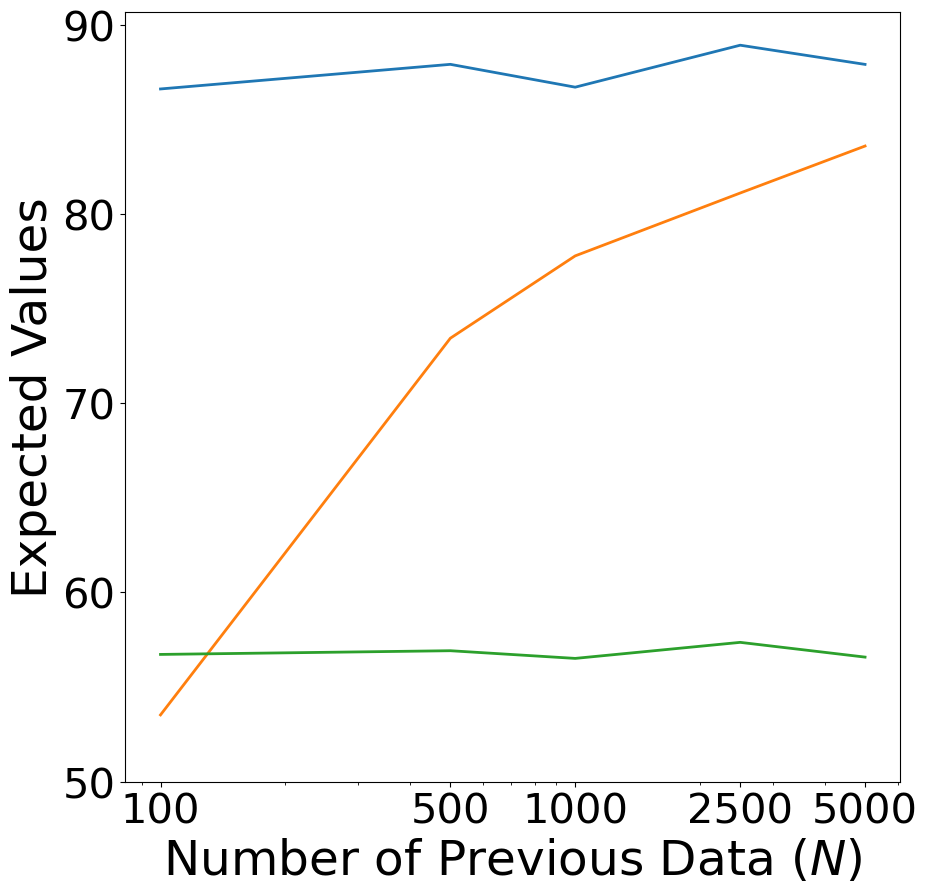

In [75]:
# 绘制结果图
plt.figure(figsize=(10, 10))  # 修改此处以创建正方形的图形
plt.plot(N_values, results_5["max_welfare_5"], label="Max Welfare", linewidth=2)
plt.plot(N_values, results_5["payment_5"], label="Payment", linewidth=2)
plt.plot(N_values, results_5["sb_value_5"], label="2nd Best Price", linewidth=2)

# 设置坐标轴标签和字体大小
plt.xlabel("Number of Previous Data ($N$)", fontsize=35)
plt.ylabel("Expected Values", fontsize=35)

# 设置图例和字体大小
#plt.legend(fontsize=30, bbox_to_anchor=(0.49, 0.45), loc='center left')

# 设置横坐标为对数尺度，并确保刻度清晰
plt.xscale("log")

# 设置刻度标签的字体大小
plt.xticks(N_values, labels=[str(N) for N in N_values], fontsize=30)
plt.yticks(np.linspace(50, 90, 5), fontsize=30)

plt.show()


In [54]:
np.random.seed(1)
# 设置 N 的不同值
N_values = [100, 500, 1000, 2500, 5000]
z_0 = 7
num_runs = 1000

# 初始化用于存储结果的字典
results_7 = {"payment_7": [], "sb_value_7": [], "max_welfare_7": []}

# 对于每个 N 值，运行函数 200 次并计算平均值
for N in N_values:
    payments_7, sb_values_7, max_welfares_7 = [], [], []
    for _ in range(num_runs):
        payment, _, _, sb_value, max_welfare = conformal_predict(50, z_0, N)
        payments_7.append(payment)
        sb_values_7.append(sb_value)
        max_welfares_7.append(max_welfare)
    results_7["payment_7"].append(np.mean(payments_7))
    results_7["sb_value_7"].append(np.mean(sb_values_7))
    results_7["max_welfare_7"].append(np.mean(max_welfares_7))

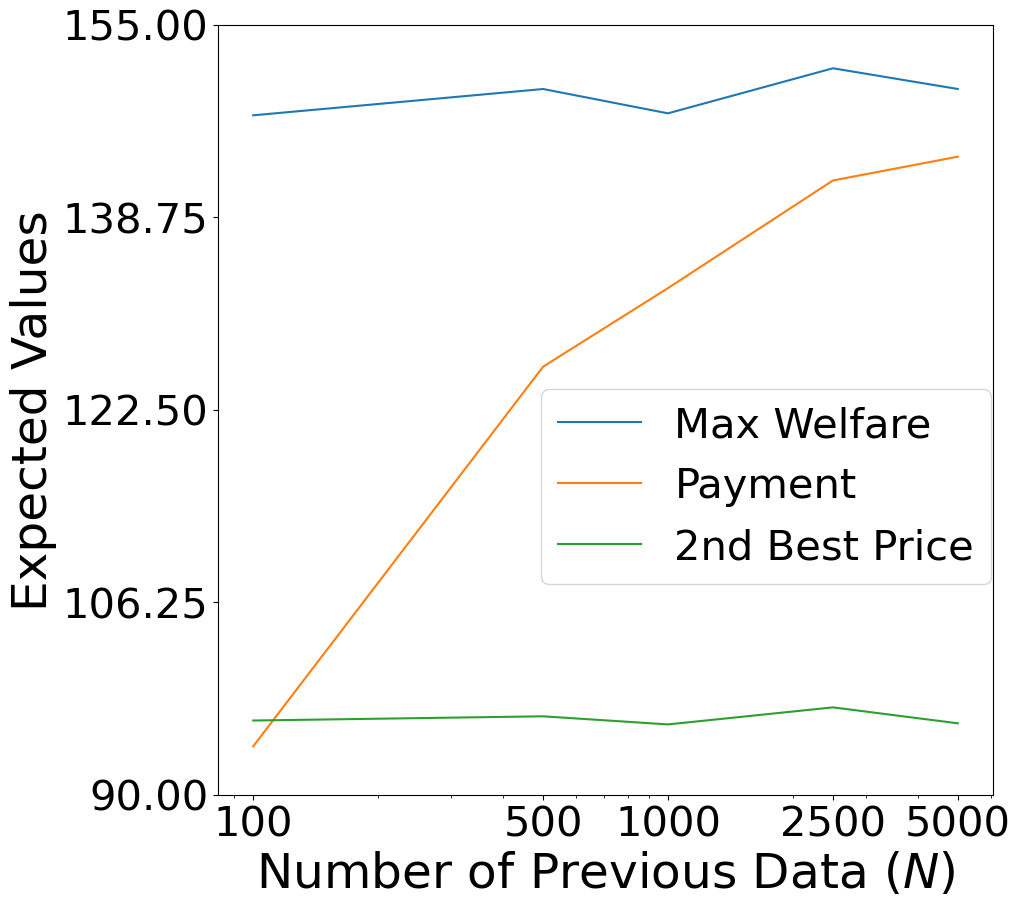

In [73]:
# 绘制结果图
plt.figure(figsize=(10, 10))
plt.plot(N_values, results_7["max_welfare_7"], label="Max Welfare")
plt.plot(N_values, results_7["payment_7"], label="Payment")
plt.plot(N_values, results_7["sb_value_7"], label="2nd Best Price")


# 设置坐标轴标签和字体大小
plt.xlabel("Number of Previous Data ($N$)", fontsize=35)
plt.ylabel("Expected Values", fontsize=35)

# 设置图例和字体大小
plt.legend(fontsize=30, bbox_to_anchor=(0.39, 0.4), loc='center left')

# 设置横坐标为对数尺度，并确保刻度清晰
plt.xscale("log")

# 设置刻度标签的字体大小
plt.xticks(N_values, labels=[str(N) for N in N_values], fontsize=30)
plt.yticks(np.linspace(90, 155, 5), fontsize=30)

plt.show()

In [57]:
np.random.seed(1)
# 设置 m 的不同值
m_values = list(range(50, 401, 50))
N = 1000
z_0 = 3
num_runs = 700

# 初始化用于存储结果的字典
results_m = {"payment": [], "y_value": [], "max_welfare": []}

# 对于每个 m 值，运行函数 700 次并计算平均值
for m in m_values:
    payments, y_values, max_welfares = [], [], []
    for _ in range(num_runs):
        payment, _, _, y_value, max_welfare = conformal_predict(m, z_0, N)
        payments.append(payment)
        y_values.append(y_value)
        max_welfares.append(max_welfare)
    results_m["payment"].append(np.mean(payments))
    results_m["y_value"].append(np.mean(y_values))
    results_m["max_welfare"].append(np.mean(max_welfares))

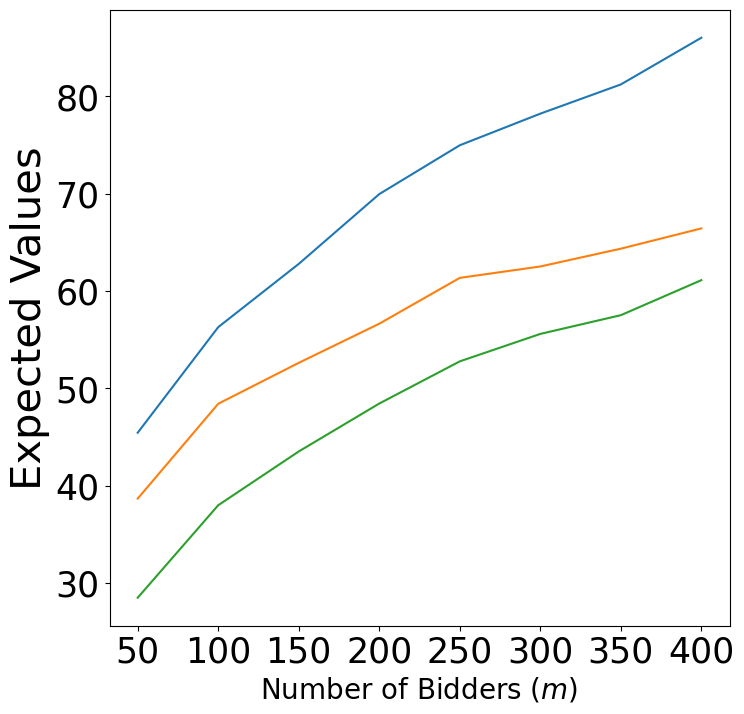

In [62]:
# 绘制结果图
plt.figure(figsize=(8, 8))
plt.plot(m_values, results_m["max_welfare"], label="Max Welfare")
plt.plot(m_values, results_m["payment"], label="Payment")
plt.plot(m_values, results_m["y_value"], label="2nd Best Price")

plt.xlabel("Number of Bidders $(m)$", fontsize=20)
plt.ylabel("Expected Values", fontsize=30)
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.title("")#Average Payment, 2nd Best Price, and Max Welfare for Different m Values
# 设置图例和字体大小
#plt.legend(fontsize=20, bbox_to_anchor=(0.0, 1), loc='upper left')
plt.show()


In [60]:
np.random.seed(1)
# 设置 m 的不同值
m_values = list(range(50, 401, 50))
N = 1000
z_0 = 5
num_runs = 700

# 初始化用于存储结果的字典
results_m_5 = {"payment": [], "y_value": [], "max_welfare": []}

# 对于每个 m 值，运行函数 500 次并计算平均值
for m in m_values:
    payments_5, y_values_5, max_welfares_5 = [], [], []
    for _ in range(num_runs):
        payment, _, _, y_value, max_welfare = conformal_predict(m, z_0, N)
        payments_5.append(payment)
        y_values_5.append(y_value)
        max_welfares_5.append(max_welfare)
    results_m_5["payment"].append(np.mean(payments_5))
    results_m_5["y_value"].append(np.mean(y_values_5))
    results_m_5["max_welfare"].append(np.mean(max_welfares_5))

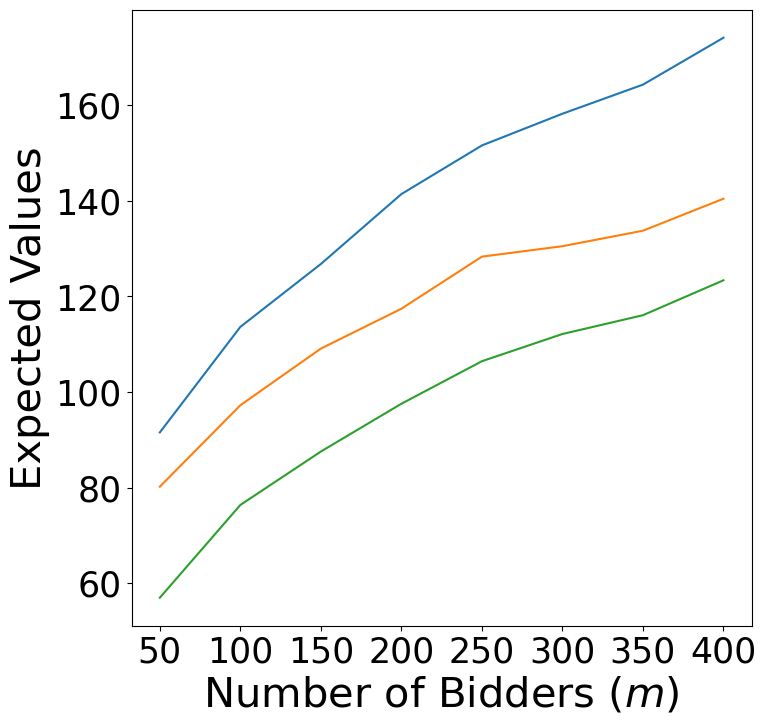

In [71]:
# 绘制结果图
plt.figure(figsize=(8, 8))
plt.plot(m_values, results_m_5["max_welfare"], label="Max Welfare")
plt.plot(m_values, results_m_5["payment"], label="Payment")
plt.plot(m_values, results_m_5["y_value"], label="2nd Best Price")

plt.xlabel("Number of Bidders $(m)$", fontsize=30)
plt.ylabel("Expected Values", fontsize=30)
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.title("")#Average Payment, 2nd Best Price, and Max Welfare for Different m Values
# 设置图例和字体大小
#plt.legend(fontsize=20, bbox_to_anchor=(0.0, 1), loc='upper left')
plt.show()

In [65]:
np.random.seed(1)
# 设置 m 的不同值
m_values = list(range(50, 401, 50))
N = 1000
z_0 = 7
num_runs = 700

# 初始化用于存储结果的字典
results_m_7 = {"payment": [], "y_value": [], "max_welfare": []}

# 对于每个 m 值，运行函数 500 次并计算平均值
for m in m_values:
    payments_7, y_values_7, max_welfares_7 = [], [], []
    for _ in range(num_runs):
        payment, _, _, y_value, max_welfare = conformal_predict(m, z_0, N)
        payments_7.append(payment)
        y_values_7.append(y_value)
        max_welfares_7.append(max_welfare)
    results_m_7["payment"].append(np.mean(payments_7))
    results_m_7["y_value"].append(np.mean(y_values_7))
    results_m_7["max_welfare"].append(np.mean(max_welfares_7))

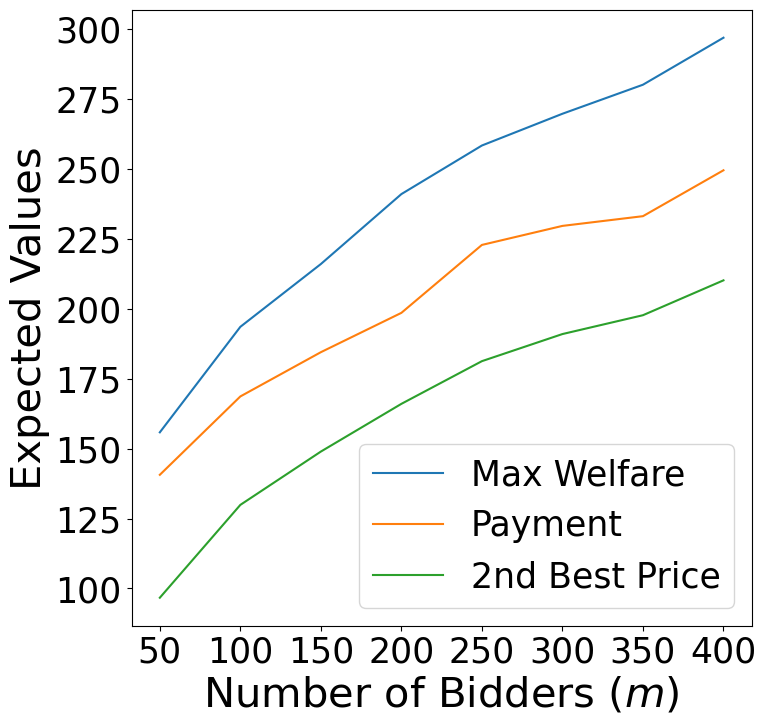

In [69]:
# 绘制结果图
plt.figure(figsize=(8, 8))
plt.plot(m_values, results_m_7["max_welfare"], label="Max Welfare")
plt.plot(m_values, results_m_7["payment"], label="Payment")
plt.plot(m_values, results_m_7["y_value"], label="2nd Best Price")


plt.xlabel("Number of Bidders $(m)$", fontsize=30)
plt.ylabel("Expected Values", fontsize=30)
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.title("")#Average Payment, 2nd Best Price, and Max Welfare for Different m Values
# 设置图例和字体大小
plt.legend(fontsize=25, loc='lower right')
plt.show()
